# Raw SQL x ORM Benchmarks

_Vojtěch Lengál_


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def read_sqlite_data(benchmark_name):
    data = pd.read_csv(f"data/sqlite/DbBenchmarks.{benchmark_name}-report.csv", sep=";")
    return (data.iloc[0], data.iloc[1])


def read_mssql_data(benchmark_name):
    data = pd.read_csv(f"data/mssql/DbBenchmarks.{benchmark_name}-report.csv", sep=";")
    return (data.iloc[0], data.iloc[1])


def get_cell_number(cell):
    return float(cell.split()[0].replace(",", ""))


def get_quantiles(row):
    row_names = ["Min", "Q1", "Median", "Q3", "Max"]
    return (get_cell_number(row[name]) for name in row_names)


def get_unit(row):
    return row["Median"].split()[1]


def render_graph(raw_sql_data, ef_data, split_graphs, title):
    sql_min, sql_q1, sql_med, sql_q3, sql_max = get_quantiles(raw_sql_data)
    ef_min, ef_q1, ef_med, ef_q3, ef_max = get_quantiles(ef_data)
    unit = get_unit(raw_sql_data)

    graph_data = {
        "Raw SQL": [sql_min, sql_max, sql_med, sql_q1, sql_q3],
        "EF Core": [ef_min, ef_max, ef_med, ef_q1, ef_q3],
    }

    if split_graphs:
        # Creating a figure and axes
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        raw_sql, ef_core = "Raw SQL", "EF Core"

        # Plotting the first boxplot
        axes[0].boxplot(graph_data[raw_sql], whis=[0, 100])
        axes[0].set_ylabel(f"Duration ({unit})")
        axes[0].set_xticklabels([raw_sql])

        # Plotting the second boxplot
        axes[1].boxplot(graph_data[ef_core], whis=[0, 100])
        axes[1].set_ylabel(f"Duration ({unit})")
        axes[1].set_xticklabels([ef_core])

        # Add common title
        fig.suptitle(title)

        # Adjusting the spacing between subplots
        plt.subplots_adjust(wspace=0.4)

        # Display the plot
        plt.show()
    else:
        # Create a figure and axis
        fig, ax = plt.subplots()

        # Create the boxplot
        ax.boxplot(graph_data.values(), labels=graph_data.keys(), whis=[0, 100])

        # Customize the plot
        ax.set_title(title)
        ax.set_ylabel(f"Duration ({unit})")

        # Show the plot
        plt.show()


def render_benchmark_graphs(
    benchmark_name_raw, benchmark_name_to_display, split_sqlite_graph, split_mssql_graph
):
    sqlite_raw_sql, sqlite_ef = read_sqlite_data(benchmark_name_raw)
    mssql_raw_sql, mssql_ef = read_mssql_data(benchmark_name_raw)

    render_graph(
        sqlite_raw_sql,
        sqlite_ef,
        split_sqlite_graph,
        f"Benchmark: {benchmark_name_to_display} - SQLite",
    )
    render_graph(
        mssql_raw_sql,
        mssql_ef,
        split_mssql_graph,
        f"Benchmark: {benchmark_name_to_display} - SQL Server",
    )


## Intro

In this experiment, we're going to analyze performance overhead of using [EF Core](https://learn.microsoft.com/en-us/ef/) (ORM framework for .NET) compared to raw SQL queries.

TODO
We're going to run these benchmarks on 2 DBs

- SQLite (embedded DB)
- SQL Server

### Expected results:


## Testing data

Our data model represents a simple e-shop with the following entities:

- Category
- Product
- Order
- Customer

Here's a UML model of our data:

![](./diagrams/data_model.png)

I generated the test data, i.e.

- 1,000 Categories
- 1,000,000 Products
- 100,000 Orders (each order has <= 10 products)
- 1,000 Customers

using [Bogus](https://github.com/bchavez/Bogus) library.

So, all of the following benchmarks are ran on these data.

## Benchmarks

Below, there's a list of benchmark I ran.

### Get top 1000 products

This benchmark just selects the first 1000 products (with no relations loaded) and returns them in a `List`.

#### Expectation

I expected raw SQL queries to be a little bit faster, which is natural, because ORM under the hood converts queries to SQL and furthermore adds some extra overhead.  
But in this case, the overhead of using ORM shouldn't be significant, maybe just mapping rows to objects, which is done using reflection can take a non-trivial amount of time.

#### Results


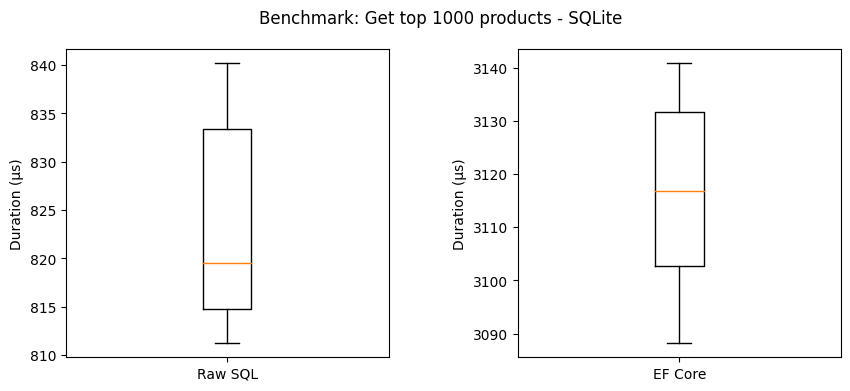

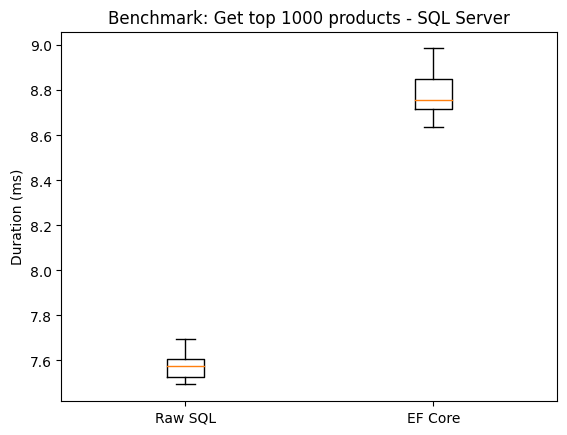

In [111]:
benchmark_name_raw = "GetTop1000ProductsBenchmark"

render_benchmark_graphs(benchmark_name_raw, "Get top 1000 products", True, False)


#### Conclusions


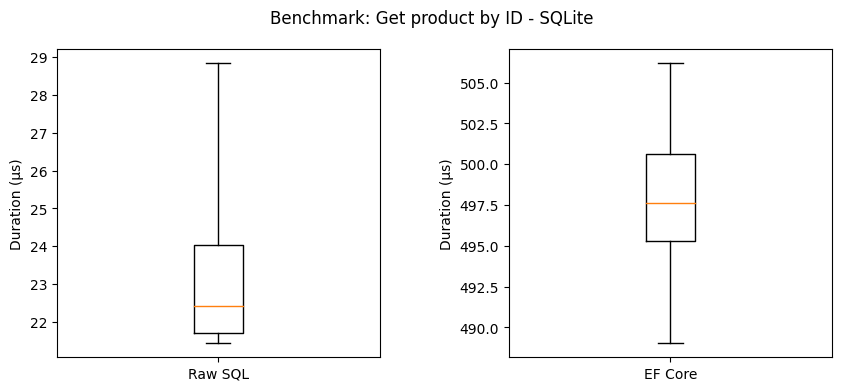

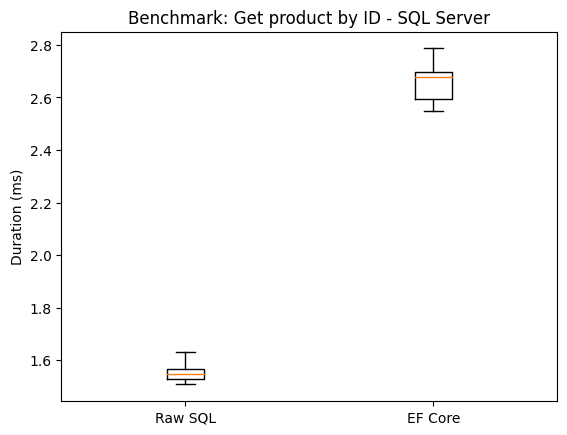

In [110]:
benchmark_name_raw = "GetProductByIdBenchmark"

render_benchmark_graphs(benchmark_name_raw, "Get product by ID", True, False)

### Consistency

It's also important to mention benchmark consistency.  
I tried to run all of the benchmarks multiple times, and the results were very similar, so from this point of view, we can say that all benchmarks are consistent.


## Build & run

Prerequisites:

- .NET 7
- Docker Compose / local instance of SQL Server

Run

```
docker compose up
```

to start SQL Server DB in a container (`localhost:5555`)

---

Run

```
dotnet run --project DbBenchmarks
```

to run the benchmarks.

### Platform description

All of the data were collected on my laptop, which has the following specification:

- Windows 11
- CPU: AMD Ryzen 7 5700U with Radeon Graphics
- .NET 7.0

## Final conclusions
